In [1]:
#Librerias que importo para el clasificador de imagenes
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, Input
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.utils import np_utils
import os
import numpy as np
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator 
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')

In [2]:
width_shape = 224
height_shape = 224
num_classes = 8
epochs = 10
batch_size = 32 

In [3]:
train_data = 'CarneDataset/train'
test_data = 'CarneDataset/test'

In [4]:
gene_train = ImageDataGenerator(  
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    preprocessing_function=preprocess_input)

gen_test = ImageDataGenerator(    
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    preprocessing_function=preprocess_input)

train_generator = gene_train.flow_from_directory(  
    train_data,
    target_size=(width_shape, height_shape),
    batch_size=batch_size,
    #save_to_dir='',
    class_mode='categorical')

validation_generator = gen_test.flow_from_directory(  
    test_data,
    target_size=(width_shape, height_shape),
    batch_size=batch_size,
    #save_to_dir='',
    class_mode='categorical')

Found 1633 images belonging to 8 classes.
Found 810 images belonging to 8 classes.


In [5]:
train_samples = 1633
test_samples = 810

In [6]:
#Modelo CNN
model = Sequential()

inputShape = (height_shape, width_shape, 3)
model.add(Conv2D(32,(3,3), input_shape=inputShape))
model.add(MaxPool2D())
          
model.add(Conv2D(64,(3,3)))

model.add(Flatten())
model.add(Dense(num_classes,activation='softmax', name='output'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 flatten (Flatten)           (None, 760384)            0         
                                                                 
 output (Dense)              (None, 8)                 6083080   
                                                                 
Total params: 6,102,472
Trainable params: 6,102,472
Non-trainable params: 0
______________________________________________

In [7]:
#Compilacion del modelo CNN
model.compile(loss='categorical_crossentropy',optimizer='adadelta',metrics=['accuracy'])

In [8]:
#Modelo historico / entrenamiento del modelo CNN
model_history = model.fit_generator(  
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    steps_per_epoch=train_samples//batch_size,
    validation_steps=test_samples//batch_size)

C:\Users\bflorencia\AppData\Local\Temp\ipykernel_29924\849528261.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history = model.fit_generator(


Epoch 1/10
51/51 [==============================] - 135s 3s/step - loss: 17.1526 - accuracy: 0.4603 - val_loss: 13.5875 - val_accuracy: 0.5125
Epoch 2/10
51/51 [==============================] - 135s 3s/step - loss: 12.2597 - accuracy: 0.5334 - val_loss: 10.7366 - val_accuracy: 0.5700
Epoch 3/10
51/51 [==============================] - 140s 3s/step - loss: 10.9298 - accuracy: 0.5634 - val_loss: 11.0843 - val_accuracy: 0.6012
Epoch 4/10
51/51 [==============================] - 145s 3s/step - loss: 10.0775 - accuracy: 0.5815 - val_loss: 9.2059 - val_accuracy: 0.5962
Epoch 5/10
51/51 [==============================] - 173s 3s/step - loss: 9.6336 - accuracy: 0.6002 - val_loss: 8.9898 - val_accuracy: 0.5987
Epoch 6/10
51/51 [==============================] - 175s 3s/step - loss: 8.7177 - accuracy: 0.6171 - val_loss: 9.8948 - val_accuracy: 0.5913
Epoch 7/10
51/51 [==============================] - 172s 3s/step - loss: 8.0023 - accuracy: 0.6352 - val_loss: 8.2058 - val_accuracy: 0.6375
Epoch 

In [9]:
#Guardar en un archivo el modelo CNN
model.save("model_cnn.h5")

In [10]:
#Modelo Mobilenet
from keras.applications.mobilenet import MobileNet


image_input = Input(shape=(width_shape, height_shape, 3))

m_MobileNet = MobileNet(input_tensor=image_input, include_top=False,weights='imagenet')


m_MobileNet.summary()

last_layer = m_MobileNet.layers[-1].output
x= Flatten(name='flatten')(last_layer)
x = Dense(128, activation='relu', name='fc1')(x)
x=Dropout(0.3)(x)
x = Dense(128, activation='relu', name='fc2')(x)
x=Dropout(0.3)(x)
out = Dense(num_classes, activation='softmax', name='output')(x)
custom_model = Model(image_input, out)
custom_model.summary()

#Compilacion del Mobilenet
custom_model.compile(loss='categorical_crossentropy',optimizer='adadelta',metrics=['accuracy'])

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

                                                                 
 conv_pw_8 (Conv2D)          (None, 14, 14, 512)       262144    
                                                                 
 conv_pw_8_bn (BatchNormaliz  (None, 14, 14, 512)      2048      
 ation)                                                          
                                                                 
 conv_pw_8_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_dw_9 (DepthwiseConv2D)  (None, 14, 14, 512)      4608      
                                                                 
 conv_dw_9_bn (BatchNormaliz  (None, 14, 14, 512)      2048      
 ation)                                                          
                                                                 
 conv_dw_9_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_pw_9

 conv_pw_2_bn (BatchNormaliz  (None, 56, 56, 128)      512       
 ation)                                                          
                                                                 
 conv_pw_2_relu (ReLU)       (None, 56, 56, 128)       0         
                                                                 
 conv_dw_3 (DepthwiseConv2D)  (None, 56, 56, 128)      1152      
                                                                 
 conv_dw_3_bn (BatchNormaliz  (None, 56, 56, 128)      512       
 ation)                                                          
                                                                 
 conv_dw_3_relu (ReLU)       (None, 56, 56, 128)       0         
                                                                 
 conv_pw_3 (Conv2D)          (None, 56, 56, 128)       16384     
                                                                 
 conv_pw_3_bn (BatchNormaliz  (None, 56, 56, 128)      512       
 ation)   

 conv_dw_11_bn (BatchNormali  (None, 14, 14, 512)      2048      
 zation)                                                         
                                                                 
 conv_dw_11_relu (ReLU)      (None, 14, 14, 512)       0         
                                                                 
 conv_pw_11 (Conv2D)         (None, 14, 14, 512)       262144    
                                                                 
 conv_pw_11_bn (BatchNormali  (None, 14, 14, 512)      2048      
 zation)                                                         
                                                                 
 conv_pw_11_relu (ReLU)      (None, 14, 14, 512)       0         
                                                                 
 conv_pad_12 (ZeroPadding2D)  (None, 15, 15, 512)      0         
                                                                 
 conv_dw_12 (DepthwiseConv2D  (None, 7, 7, 512)        4608      
 )        

In [11]:
#Modelo historico / entrenamiento del modelo Mobilnet
model_history = custom_model.fit_generator(  
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    steps_per_epoch=train_samples//batch_size,
    validation_steps=test_samples//batch_size)

C:\Users\bflorencia\AppData\Local\Temp\ipykernel_29924\1296320928.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history = custom_model.fit_generator(


Epoch 1/10
51/51 [==============================] - 359s 7s/step - loss: 2.7341 - accuracy: 0.2561 - val_loss: 1.7614 - val_accuracy: 0.4200
Epoch 2/10
51/51 [==============================] - 331s 7s/step - loss: 2.1807 - accuracy: 0.3698 - val_loss: 1.5135 - val_accuracy: 0.5600
Epoch 3/10
51/51 [==============================] - 336s 7s/step - loss: 2.0267 - accuracy: 0.4285 - val_loss: 1.4610 - val_accuracy: 0.5562
Epoch 4/10
51/51 [==============================] - 337s 7s/step - loss: 1.9261 - accuracy: 0.4453 - val_loss: 1.4174 - val_accuracy: 0.5800
Epoch 5/10
51/51 [==============================] - 334s 7s/step - loss: 1.7964 - accuracy: 0.4797 - val_loss: 1.3270 - val_accuracy: 0.6037
Epoch 6/10
51/51 [==============================] - 341s 7s/step - loss: 1.7359 - accuracy: 0.4834 - val_loss: 1.3083 - val_accuracy: 0.5987
Epoch 7/10
51/51 [==============================] - 336s 7s/step - loss: 1.5930 - accuracy: 0.5197 - val_loss: 1.2393 - val_accuracy: 0.6125
Epoch 8/10
51

In [12]:
#Guardar en un archivo el modelo Mobilenet
custom_model.save("model_Mobilenet.h5")

In [13]:
#Gráficas de train y test (ultima corrida - mobilenet)
def plotTraining(hist, epochs, typeData):
    
    if typeData=="loss":
        plt.figure(1,figsize=(10,5))
        yc=hist.history['loss']
        xc=range(epochs)
        plt.ylabel('Loss', fontsize=24)
        plt.plot(xc,yc,'-r',label='Loss Training')
    if typeData=="accuracy":
        plt.figure(2,figsize=(10,5))
        yc=hist.history['accuracy']
        for i in range(0, len(yc)):
            yc[i]=100*yc[i]
        xc=range(epochs)
        plt.ylabel('Accuracy (%)', fontsize=24)
        plt.plot(xc,yc,'-r',label='Accuracy Training')
    if typeData=="val_loss":
        plt.figure(1,figsize=(10,5))
        yc=hist.history['val_loss']
        xc=range(epochs)
        plt.ylabel('Loss', fontsize=24)
        plt.plot(xc,yc,'--b',label='Loss Validate')
    if typeData=="val_accuracy":
        plt.figure(2,figsize=(10,5))
        yc=hist.history['val_accuracy']
        for i in range(0, len(yc)):
            yc[i]=100*yc[i]
        xc=range(epochs)
        plt.ylabel('Accuracy (%)', fontsize=24)
        plt.plot(xc,yc,'--b',label='Training Validate')
        

    plt.rc('xtick',labelsize=24)
    plt.rc('ytick',labelsize=24)
    plt.rc('legend', fontsize=18) 
    plt.legend()
    plt.xlabel('Number of Epochs',fontsize=24)
    plt.grid(True)

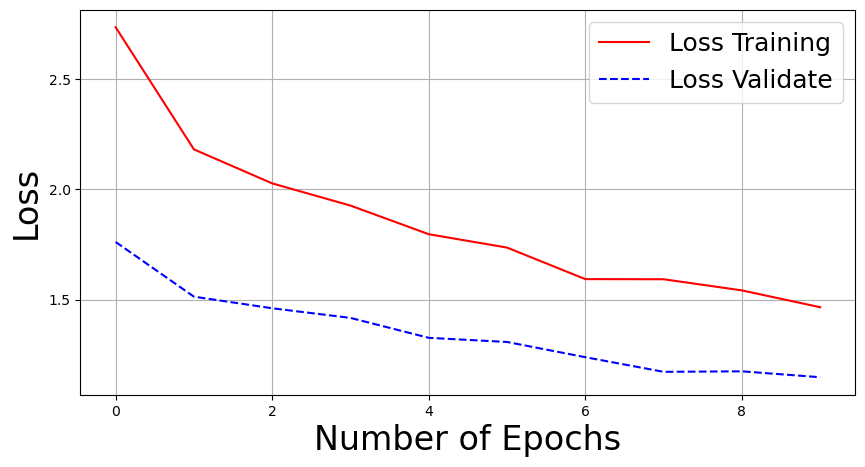

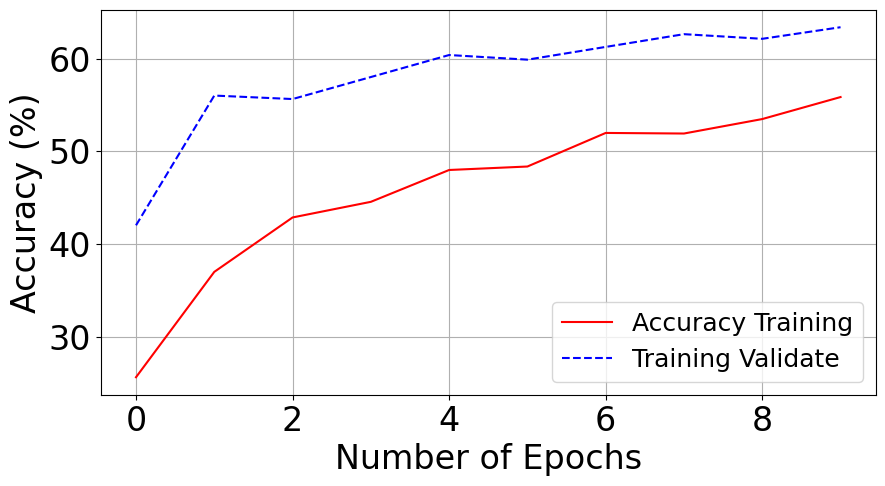

In [14]:
#Muestra la grafica de historial de entrenamiento perdida vs precision (ultima corrida - mobilenet)
plotTraining(model_history,epochs,"loss")
plotTraining(model_history,epochs,"accuracy")
plotTraining(model_history,epochs,"val_loss")
plotTraining(model_history,epochs,"val_accuracy")

1/1 [==============================] - 0s 199ms/step
CLASS_04


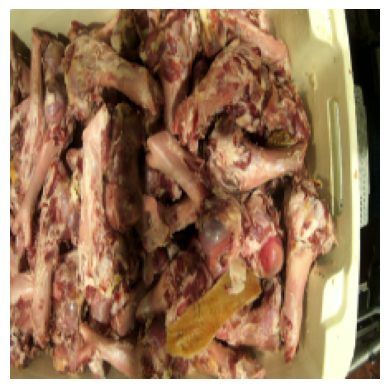

In [15]:
# Verificar si el entrenamiento funciona seleccionando una imagen y 
#buscandola dentro de las clases de los modelos guardados usando el modelo CNN.
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.models import load_model
names = ['CLASS_01', 'CLASS_02', 'CLASS_03', 'CLASS_04', 'CLASS_05', 'CLASS_06', 'CLASS_07', 'CLASS_08']

modelt = load_model("model_cnn.h5")

imaget_path = r"C:\Users\bflorencia\Downloads\Temporal BF\Github\Tarea_Finla_TD_BAFM\CarneDataset\imagenPrueba.png"
imaget=cv2.resize(cv2.imread(imaget_path), (width_shape, height_shape), interpolation = cv2.INTER_AREA)
xt = np.asarray(imaget)
xt=preprocess_input(xt)
xt = np.expand_dims(xt,axis=0)
preds = modelt.predict(xt)

print(names[np.argmax(preds)])
plt.imshow(cv2.cvtColor(np.asarray(imaget),cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

1/1 [==============================] - 1s 558ms/step
CLASS_05


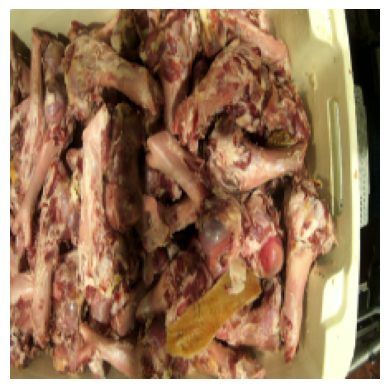

In [16]:
# Verificar si el entrenamiento funciona seleccionando una imagen y 
#buscandola dentro de las clases de los modelos guardados usando el modelo Mobilenet.
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.models import load_model
names = ['CLASS_01', 'CLASS_02', 'CLASS_03', 'CLASS_04', 'CLASS_05', 'CLASS_06', 'CLASS_07', 'CLASS_08']

modelt = load_model("model_Mobilenet.h5")

imaget_path = r"C:\Users\bflorencia\Downloads\Temporal BF\Github\Tarea_Finla_TD_BAFM\CarneDataset\imagenPrueba.png"
imaget=cv2.resize(cv2.imread(imaget_path), (width_shape, height_shape), interpolation = cv2.INTER_AREA)
xt = np.asarray(imaget)
xt=preprocess_input(xt)
xt = np.expand_dims(xt,axis=0)
preds = modelt.predict(xt)

print(names[np.argmax(preds)])
plt.imshow(cv2.cvtColor(np.asarray(imaget),cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

Found 810 images belonging to 8 classes.


C:\Users\bflorencia\AppData\Local\Temp\ipykernel_29924\1149580317.py:25: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = custom_Model.predict_generator(generator=test_generator)
C:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         1
           1     0.0000    0.0000    0.0000        48
           2     0.2034    0.1237    0.1538        97
           3     0.1579    0.2000    0.1765        45
           4     0.6869    0.9129    0.7839       459
           5     0.2500    0.1053    0.1481        19
           6     0.4324    0.2807    0.3404       114
           7     0.0000    0.0000    0.0000        27

    accuracy                         0.5852       810
   macro avg     0.2163    0.2028    0.2004       810
weighted avg     0.4891    0.5852    0.5238       810



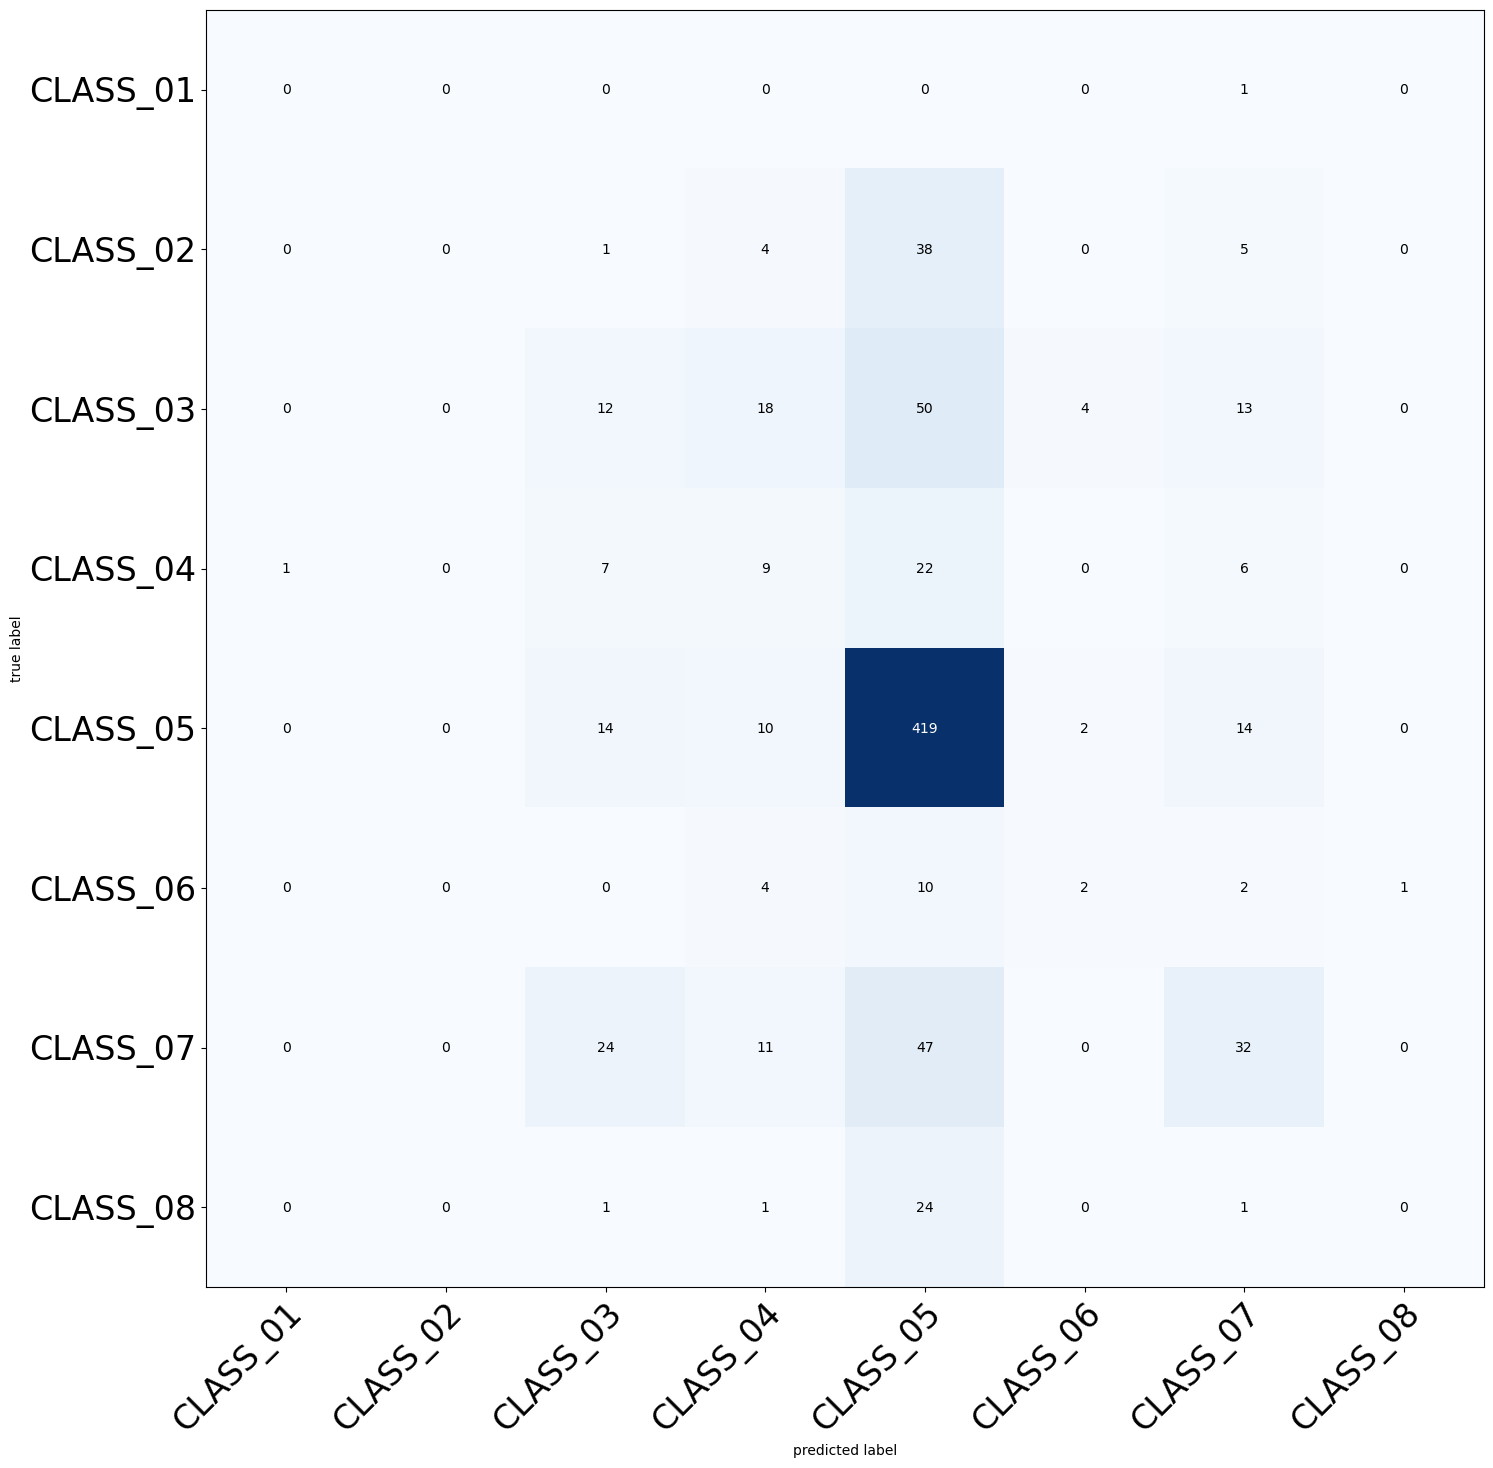

In [17]:
#Generacion de matrices de confusion
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn import metrics
from mlxtend.plotting import plot_confusion_matrix
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')

names = ['CLASS_01', 'CLASS_02', 'CLASS_03', 'CLASS_04', 'CLASS_05', 'CLASS_06', 'CLASS_07', 'CLASS_08']
test_data_dir = 'CarneDataset/test'

test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(width_shape, height_shape), 
    batch_size = batch_size,
    class_mode='categorical', 
    shuffle=False)

custom_Model= load_model("model_Mobilenet.h5")
#modelt = custom_model

predictions = custom_Model.predict_generator(generator=test_generator)

y_pred = np.argmax(predictions, axis=1)
y_real = test_generator.classes


matc=confusion_matrix(y_real, y_pred)

plot_confusion_matrix(conf_mat=matc, figsize=(15,15), class_names = names, show_normed=False)
plt.tight_layout()

print(metrics.classification_report(y_real,y_pred, digits = 4))

Found 810 images belonging to 8 classes.


C:\Users\bflorencia\AppData\Local\Temp\ipykernel_29924\891390343.py:25: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = custom_Model.predict_generator(generator=test_generator)
C:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.p

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         1
           1     0.0773    0.9583    0.1431        48
           2     0.0000    0.0000    0.0000        97
           3     0.0000    0.0000    0.0000        45
           4     0.0000    0.0000    0.0000       459
           5     0.0857    0.9474    0.1572        19
           6     0.0000    0.0000    0.0000       114
           7     0.0000    0.0000    0.0000        27

    accuracy                         0.0790       810
   macro avg     0.0204    0.2382    0.0375       810
weighted avg     0.0066    0.0790    0.0122       810



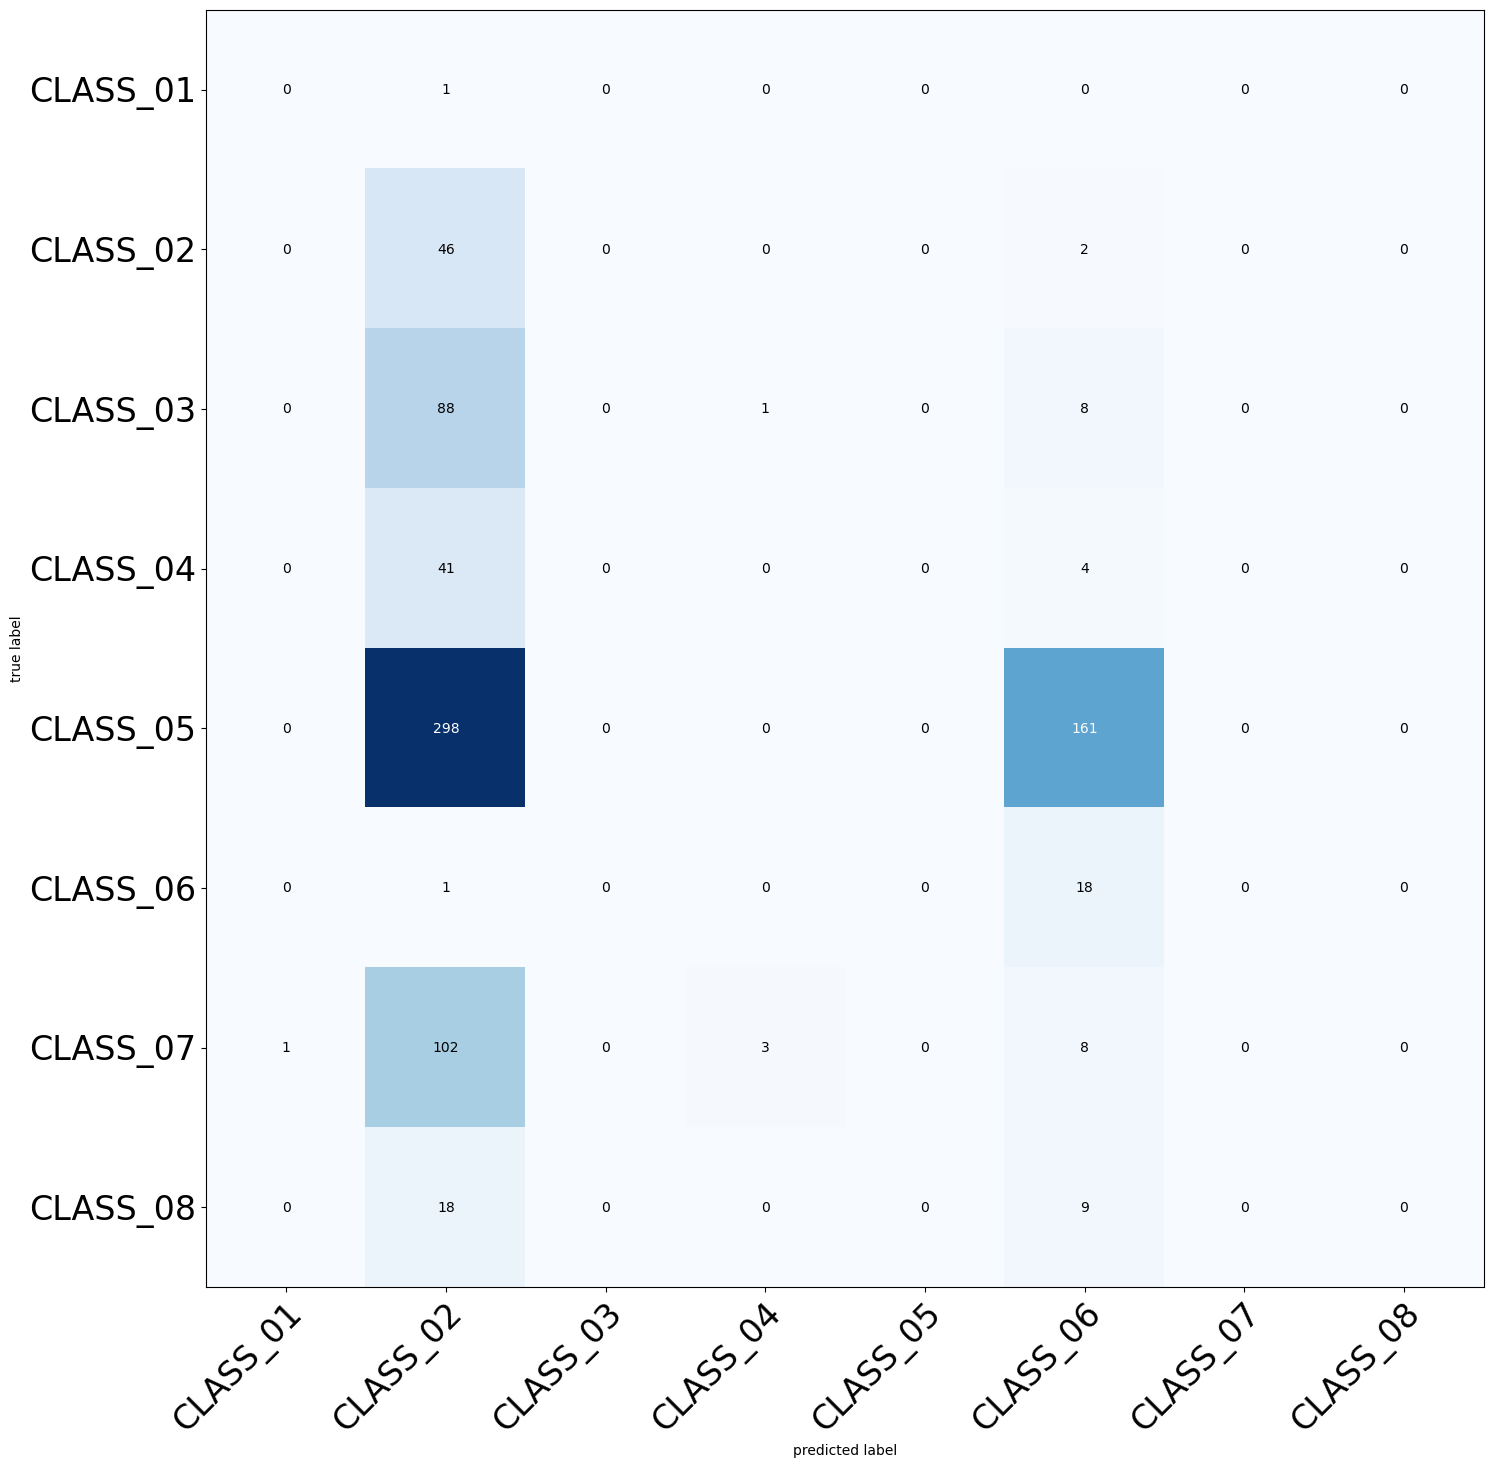

In [19]:
#Generacion de matrices de confusion
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn import metrics
from mlxtend.plotting import plot_confusion_matrix
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')

names = ['CLASS_01', 'CLASS_02', 'CLASS_03', 'CLASS_04', 'CLASS_05', 'CLASS_06', 'CLASS_07', 'CLASS_08']
test_data_dir = 'CarneDataset/test'

test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(width_shape, height_shape), 
    batch_size = batch_size,
    class_mode='categorical', 
    shuffle=False)

custom_Model= load_model("model_cnn.h5")
#modelt = custom_model

predictions = custom_Model.predict_generator(generator=test_generator)

y_pred = np.argmax(predictions, axis=1)
y_real = test_generator.classes


matc=confusion_matrix(y_real, y_pred)

plot_confusion_matrix(conf_mat=matc, figsize=(15,15), class_names = names, show_normed=False)
plt.tight_layout()

print(metrics.classification_report(y_real,y_pred, digits = 4))